In [143]:
import pandas as pd # используем модуль pandas для чтения данных из csv файла
import numpy as np 
import seaborn as sns # seaborn используем для отрисовки графиков
from matplotlib import pyplot as plt # matplotlib - аналогично
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler # используем MinMaxScaler для увеличения точности алгоритма

from catboost import CatBoostRegressor # наш регрессор

from sklearn.model_selection import cross_val_score # функция для кросс-валидации

In [167]:
data = pd.read_csv('data/forest.csv') # считаем данные из таблицы

In [168]:
data.head() # посмотрим первые 5 строк

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Начнем анализировать данные

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Заметим, что данные достаточно "лабораторные" - не имеется nan значений

In [169]:
X, y = data[data.columns[:-1]], data['area'] # выделим в отдельную переменную "то, что нужно предсказать"

In [170]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


1) посмотрим корелляцию между различными фичами

In [171]:
def get_corr_among_features(X):
    mask = np.zeros_like(X.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.subplots(figsize = (15,12))
    sns.heatmap(X.corr(), 
                annot=True,
                mask = mask,
                cmap = 'RdBu_r',
                linewidths=0.1, 
                linecolor='white',
                vmax = .9,
                square=True)
    plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

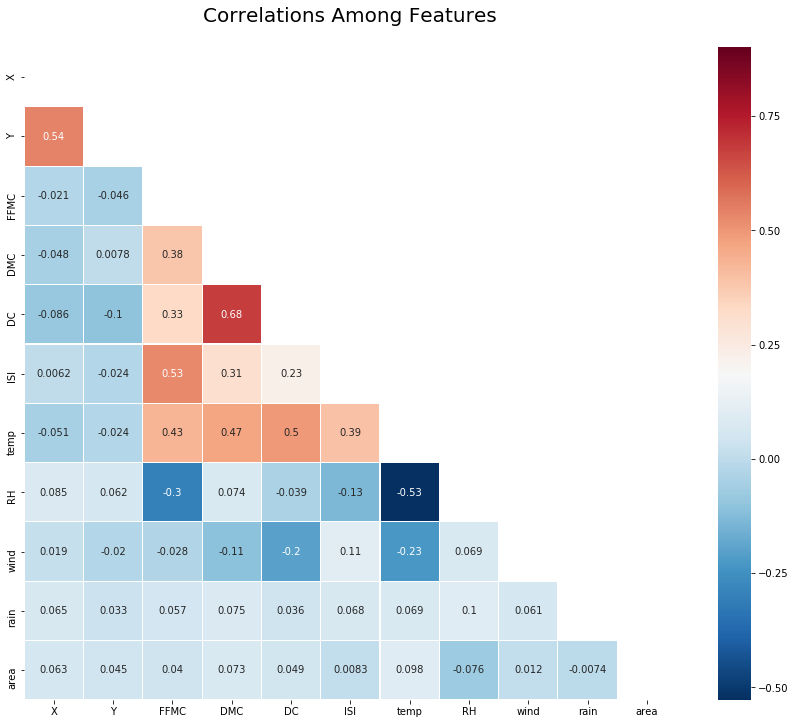

In [172]:
get_corr_among_features(data)

In [173]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


2) далеее посмотрим "важность" различных фичей

In [174]:
def get_feature_importance(X, y): 
  cat_features = [0, 1]
  model = CatBoostRegressor(logging_level='Silent', random_state=42)
  model.fit(X, y, cat_features)
  return model.feature_importances_

In [175]:
def plot_of_feature_importance(X, fi):
  indices = np.argsort(fi)[::-1]
  names = [list(X.columns)[i] for i in indices]
  plt.figure()
  plt.title("Feature Importance")
  plt.bar(range(X.shape[1]), fi[indices])
  plt.xticks(range(X.shape[1]), names, rotation=90)
  plt.show()

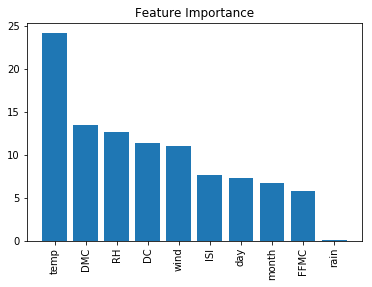

In [156]:
feature_importance = get_feature_importance(X, y)
plot_of_feature_importance(X, feature_importance)

3) напишем функцию для one hot encoding для двух категориальных фич

In [176]:
def one_hot_encoding(__X):
    to_encode = ['month', 'day']
    one_hot = pd.get_dummies(__X[to_encode])
    __X = __X.drop(to_encode, axis=1)
    __X = __X.join(one_hot)
    return __X

4) напишем функцию для выведения score от кросс-валидации

In [177]:
def get_cross_vall_score(model_, _data):
    dt = _data.copy()
    cl = dt.columns[:-1]
    _X, _y = dt[cl], dt['area']
    model = model_
    sc = cross_val_score(model, _X, _y, cv=10, scoring='neg_mean_squared_error')
    return sc, sc.mean(), sc.std() * 2

5) самое интересное - посмотрим на целевую переменную

C:\Users\egorp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


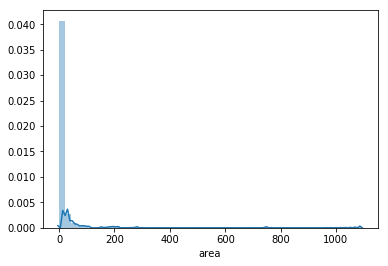

In [178]:
sns.distplot(y)

Заметим, что значения распределены очень неравномерно. Чтобы это исправить отбросим все значения больше 0 и прологорифмируем

C:\Users\egorp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


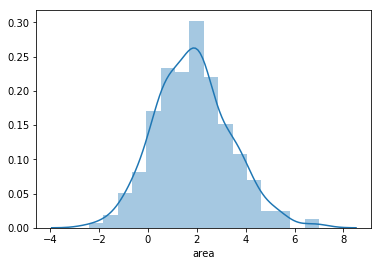

In [179]:
sns.distplot(np.log(y[y > 0.0]))

Ну вот, теперь это более презентабельно =)

6) посмотрим значение mse для "чистого" датасета без преобразований (только замена категориальных фич)

In [164]:
sc, mean, std = get_cross_vall_score(CatBoostRegressor(logging_level='Silent'), one_hot_encoding(data))
print(sc, mean, std)

[-1.15372196e+00 -3.66138357e+00 -2.77331263e+00 -6.10728102e+00
 -1.16039744e+04 -2.60328859e+01 -3.49832684e+00 -8.21491541e+01
 -1.65096052e+03 -4.96302670e+02] -1387.661362305175 6881.152974336163


-1387 - достаточно больше значение mse, будем улучшать

7) напишем функцию для преобразования данных

In [180]:
def data_processing(_data): 
    dt = _data.copy() # скопируем "чистый" датасет
    dt = dt.drop(['X', 'Y'], axis=1) # удалим поля X и Y 
    dt = dt[dt['area'] > 0] # отбросим часть датасета, в котором целевая функция равна 0
    dt['area'] = dt['area'].apply(lambda x : np.log(x)) # прологорифмируем каждое значение целевой переменной
    scaler = prcss.MinMaxScaler() # пробежимся MinMaxScaler-ом по всем колонкам кроме rain 
    col = dt.columns[2:9]
    print(col)
    for cl in col:
        dt[col] = scaler.fit_transform(dt[col])
    return dt

In [181]:
data_processing(data).head()

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'], dtype='object')


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,jul,tue,0.681957,0.156543,0.352656,0.141553,0.508039,0.333333,0.255556,0.0,-1.021651
139,sep,tue,0.840979,0.438389,0.801254,0.283105,0.627010,0.283951,0.200000,0.0,-0.843970
140,sep,mon,0.837920,0.427976,0.794038,0.283105,0.633441,0.296296,0.155556,0.0,-0.755023
141,aug,wed,0.978593,0.335647,0.589140,0.566210,0.678457,0.197531,0.455556,0.0,-0.597837
142,aug,fri,0.813456,0.363763,0.608660,0.534247,0.610932,0.444444,0.944444,0.0,-0.494296


In [182]:
sc, mean, std = get_cross_vall_score(CatBoostRegressor(logging_level='Silent'), one_hot_encoding(data_processing(data)))
print('score = {}, score_mean = {}, score_std = {}'.format(sc, mean, std))

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'], dtype='object')
score = [-0.01438681 -0.00584918 -0.03929593 -0.17696283 -0.0283374  -0.01338381
 -0.01740329 -0.12297737 -0.08386279 -0.03949998], score_mean = -0.05419593960128956, score_std = 0.10720236750066346
